<a href="https://colab.research.google.com/github/jerrysdatanote01-collab/Learn-Pytorch/blob/main/Convolutional_Neural_Network_Pytorch_(3).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

def getFile_from_drive( file_id, name ):
  downloaded = drive.CreateFile({'id': file_id})
  downloaded.GetContentFile(name)

getFile_from_drive('1Z1RqRo0_JiavaZw2yzZG6WETdZQ8qX86', 'fairface-img-margin025-trainval.zip')
getFile_from_drive('1k5vvyREmHDW5TSM9QgB04Bvc8C8_7dl-', 'fairface-label-train.csv')
getFile_from_drive('1_rtz1M1zhvS0d5vVoXUamnohB6cJ02iJ', 'fairface-label-val.csv')

!unzip -qq fairface-img-margin025-trainval.zip

In [ ]:
!pip install torch_snippets

from IPython import display
display.clear_output()

In [ ]:
from torch_snippets import *

trn_df = pd.read_csv('fairface-label-train.csv')
val_df = pd.read_csv('fairface-label-val.csv')
trn_df.head()

,file,age,gender,race,service_test
0,train/1.jpg,59,Male,East Asian,True
1,train/2.jpg,39,Female,Indian,False
2,train/3.jpg,11,Female,Black,False
3,train/4.jpg,26,Female,Indian,True
4,train/5.jpg,26,Female,Indian,True


In [ ]:
IMAGE_SIZE = 224
class GenderAgeClass(Dataset):
    def __init__(self, df, tfms=None):
        self.df = df
        self.normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    def __len__(self): return len(self.df)
    def __getitem__(self, ix):
        f = self.df.iloc[ix].squeeze()
        file = f.file
        gen = f.gender == 'Female'
        age = f.age
        im = read(file, 1)
        return im, age, gen

    def preprocess_image(self, im):
        im = resize(im, IMAGE_SIZE)
        im = torch.tensor(im).permute(2,0,1)
        im = self.normalize(im/255.)
        return im[None]

    def collate_fn(self, batch):
        'preprocess images, ages and genders'
        ims, ages, genders = [], [], []
        for im, age, gender in batch:
            im = self.preprocess_image(im)
            ims.append(im)

            ages.append(float(int(age)/80))
            genders.append(float(gender))

        ages, genders = [torch.tensor(x).to(device).float() for x in [ages, genders]]
        ims = torch.cat(ims).to(device)

        return ims, ages, genders

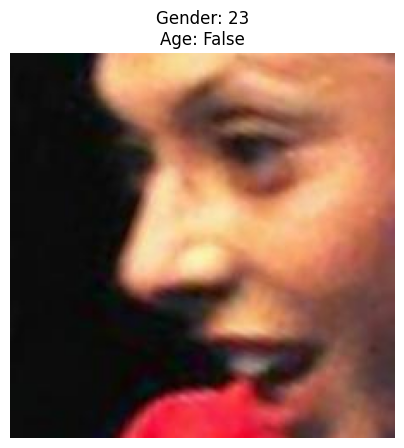

In [ ]:
trn = GenderAgeClass(trn_df)
val = GenderAgeClass(val_df)
im, gen, age = trn[5]
show(im, title=f'Gender: {gen}\nAge: {age}', sz=5)

In [ ]:
train_loader = DataLoader(trn, batch_size=32, shuffle=True, drop_last=True, collate_fn=trn.collate_fn)
test_loader = DataLoader(val, batch_size=32, collate_fn=val.collate_fn)

ims, gens, ages = next(iter(train_loader))
inspect(ims, gens, ages)

torch.Size([32, 3, 224, 224]) torch.Size([32]) torch.Size([32])


In [ ]:
def get_model():
    model = models.vgg16(pretrained = True)
    # Freeze parameters so we don't backprop through them
    for param in model.parameters():
        param.requires_grad = False
    model.avgpool = nn.Sequential(
        nn.Conv2d(512,512, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten()
    )
    class ageGenderClassifier(nn.Module):
        def __init__(self):
            super(ageGenderClassifier, self).__init__()
            self.intermediate = nn.Sequential(
                nn.Linear(2048,512),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(512,128),
                nn.ReLU(),
                nn.Dropout(0.4),
                nn.Linear(128,64),
                nn.ReLU(),
            )
            self.age_classifier = nn.Sequential(
                nn.Linear(64, 1),
                nn.Sigmoid()
            )
            self.gender_classifier = nn.Sequential(
                nn.Linear(64, 1),
                nn.Sigmoid()
            )
        def forward(self, x):
            x = self.intermediate(x)
            age = self.age_classifier(x)
            gender = self.gender_classifier(x)
            return gender, age

    model.classifier = ageGenderClassifier()

    gender_criterion = nn.BCELoss()
    age_criterion = nn.L1Loss()
    loss_functions = gender_criterion, age_criterion
    optimizer = torch.optim.Adam(model.parameters(), lr= 1e-4)

    return model.to(device), loss_functions, optimizer

model, loss_functions, optimizer = get_model()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:09<00:00, 57.4MB/s]


In [ ]:
from torchsummary import summary
summary(model, input_size=(3,224,224), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [ ]:
def train_batch(data, model, optimizer, criteria):
    model.train()
    ims, age, gender = data
    optimizer.zero_grad()
    pred_gender, pred_age = model(ims)
    gender_criterion, age_criterion = criteria
    gender_loss = gender_criterion(pred_gender.squeeze(), gender)
    age_loss = age_criterion(pred_age.squeeze(), age)
    total_loss = gender_loss + age_loss
    total_loss.backward()
    optimizer.step()
    return total_loss

def validate_batch(data, model, criteria):
    model.eval()
    ims, age, gender = data
    with torch.no_grad():
      pred_gender, pred_age = model(ims)
    gender_criterion, age_criterion = criteria
    gender_loss = gender_criterion(pred_gender.squeeze(), gender)
    age_loss = age_criterion(pred_age.squeeze(), age)
    total_loss = gender_loss + age_loss
    pred_gender = (pred_gender > 0.5).squeeze()
    gender_acc = (pred_gender == gender).float().sum()
    age_mae = torch.abs(age - pred_age).float().sum()
    return total_loss, gender_acc, age_mae

In [ ]:
model, criteria, optimizer = get_model()
val_gender_accuracies = []
val_age_maes = []
train_losses = []
val_losses = []

n_epochs = 1
best_test_loss = 1000
start = time.time()

for epoch in range(n_epochs):
    epoch_train_loss, epoch_test_loss = 0, 0
    val_age_mae, val_gender_acc, ctr = 0, 0, 0
    _n = len(train_loader)
    for ix, data in enumerate(train_loader):
        # if ix == 100: break
        loss = train_batch(data, model, optimizer, criteria)
        epoch_train_loss += loss.item()

    for ix, data in enumerate(test_loader):
        # if ix == 10: break
        loss, gender_acc, age_mae = validate_batch(data, model, criteria)
        epoch_test_loss += loss.item()
        val_age_mae += age_mae
        val_gender_acc += gender_acc
        ctr += len(data[0])

    val_age_mae /= ctr
    val_gender_acc /= ctr
    epoch_train_loss /= len(train_loader)
    epoch_test_loss /= len(test_loader)

    elapsed = time.time()-start
    best_test_loss = min(best_test_loss, epoch_test_loss)
    print('{}/{} ({:.2f}s - {:.2f}s remaining)'.format(epoch+1, n_epochs, time.time()-start, (n_epochs-epoch)*(elapsed/(epoch+1))))
    info = f'''Epoch: {epoch+1:03d}\tTrain Loss: {epoch_train_loss:.3f}\tTest: {epoch_test_loss:.3f}\tBest Test Loss: {best_test_loss:.4f}'''
    info += f'\nGender Accuracy: {val_gender_acc*100:.2f}%\tAge MAE: {val_age_mae:.2f}\n'
    print(info)

    val_gender_accuracies.append(val_gender_acc)
    val_age_maes.append(val_age_mae)

In [ ]:
epochs = np.arange(1,len(val_gender_accuracies)+1)
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax = ax.flat
ax[0].plot(epochs, [v.item() for v in val_gender_accuracies], 'bo')
ax[1].plot(epochs, [v.item() for v in val_age_maes], 'r')
ax[0].set_xlabel('Epochs')
ax[1].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[1].set_ylabel('MAE')
ax[0].set_title('Validation Gender Accuracy')
ax[0].set_title('Validation Age Mean-Absolute-Error')
plt.show()

In [ ]:
im = cv2.imread('/content/val/10110.jpg')
im = trn.preprocess_image(im).to(device)
gender, age = model(im)
pred_gender = gender.to('cpu').detach().numpy()
pred_age = age.to('cpu').detach().numpy()
im = cv2.imread('/content/val/10110.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
plt.imshow(im)
print('predicted gender:',np.where(pred_gender[0][0]<0.5,'Male','Female'), '; Predicted age', int(pred_age[0][0]*80))